## Digit Classification
Now we're going to build a larger network that can solve a (formerly) difficult problem, identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below


<img src='https://user-images.githubusercontent.com/24764528/50548844-898ff580-0c79-11e9-8bad-9c7ad0a9abf1.png' width='400px'>
Our goal is to build a neural network that can take one of these images and predict the digit in the image.

In [2]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import matplotlib.pyplot as plt

In [3]:
from torchvision import datasets , transforms

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
#Batch size determines we are getting 64 images at once 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


We have the training data loaded into trainloader and we make that an iterator with iter(trainloader). Later, we'll use this to loop through the dataset for training, like

for image, label in trainloader:
    ## do things with images and labels
    
You'll notice I created the trainloader with a batch size of 64, and shuffle=True.
The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a batch.
And shuffle=True tells it to shuffle the dataset every time we start going through the data loader again. But here I'm just grabbing the first batch so we can check out the data.

We can see below that images is just a tensor with size (64, 1, 28, 28). So, 64 images per batch, 1 color channel, and 28x28 images.

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


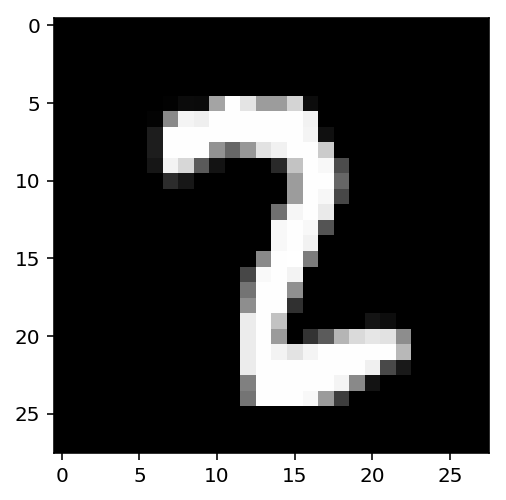

In [5]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

### Fully Connected Neural Net

 In fully-connected networks, the input to each layer must be a one-dimensional vector (which can be stacked into a 2D tensor as a batch of multiple examples).
#### Flattening
- link{https://www.youtube.com/watch?v=mFAIBMbACMA}

However, our images are 28x28 2D tensors, so we need to convert them into 1D vectors. Thinking about sizes, we need to convert the batch of images with shape (64, 1, 28, 28) to a have a shape of (64, 784), 784 is 28 times 28. This is typically called flattening, we flattened the 2D images into 1D vectors.


we need 10 output units for the 10 classes (digits). 


### Exercise:
Flatten the batch of images. Then build a multi-layer network with 784 input units, 256 hidden units, and 10 output units using random tensors for the weights and biases. For now, use a sigmoid activation for the hidden layer. 

In [6]:
#Reshaping the images 
# inputs = images.view(images.shape[0],-1)
# images.shape[0] return batch size , putting -1 is a quick way to flatten a tensor without knowing second dimension
# so final size 64,784
inputs = images.view(64,784)
n_hidden = 256
n_output = 10

# w1 and B1 weights and bias for hidden layer
w1 = torch.randn((784,256))
w2 = torch.randn((256,10))
B1 = torch.randn((1,256))
B2 = torch.randn((1,10))

def activation(x):
    return 1/(1  + torch.exp(-x))

h = activation(torch.mm(inputs,w1) + B1)
output = torch.mm(h,w2) + B2

print(output)

print(output.shape)

tensor([[  8.6133,  11.7412,  -6.5254, -12.6381,  -6.3289, -15.2273,  -0.5524,
          25.2682, -17.5737,  -4.7067],
        [  3.6202,  19.2320,   2.1570, -14.6308,  -7.5981, -11.4262,  -8.2019,
          22.3428, -20.9903,  -1.1556],
        [ 14.2610,  11.5073,  -7.5085,   4.2380, -18.0474, -22.7773,  -4.4314,
          22.5972,   0.9979,   0.5807],
        [  6.9035,   8.0865,  -7.7323, -15.3868, -12.6504, -20.6788,  -1.9003,
          31.5397,  -6.6245,  -4.8954],
        [  2.5797,  13.4820,  -5.6412, -10.7501,  -6.1787, -15.5740,  -2.6697,
          15.7563, -17.4874,  -4.9271],
        [  3.5354,  13.6537,  -6.1801, -10.5023, -10.3259, -20.0178,   4.5771,
          19.8936, -11.7105,  -6.9272],
        [  9.6405,  10.9627,  -4.4450, -13.5974, -12.8402, -22.7672,   0.6438,
          22.1266, -13.0678,  -6.2751],
        [ 12.6427,  12.3807, -11.1555,  -4.7580, -10.3622, -15.3402,  -2.1698,
          18.0319,  -9.2950, -11.8716],
        [ 12.1711,  10.2802,  -0.2230, -12.2097,


Now we have 10 outputs for our network. We want to pass in an image to our network and get out a probability distribution over the classes that tells us the likely class(es) the image belongs to.

To calculate this probability distribution, we often use the softmax function'. Mathematically this looks like

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$
What this does is squish each input $x_i$ between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilites sum up to one.

Exercise: Implement a function softmax that performs the softmax calculation and returns probability distributions for each example in the batch. Note that you'll need to pay attention to the shapes when doing this. If you have a tensor a with shape (64, 10) and a tensor b with shape (64,), doing a/b will give you an error because PyTorch will try to do the division across the columns (called broadcasting) but you'll get a size mismatch. The way to think about this is for each of the 64 examples, you only want to divide by one value, the sum in the denominator. So you need b to have a shape of (64, 1). This way PyTorch will divide the 10 values in each row of a by the one value in each row of b. Pay attention to how you take the sum as well. You'll need to define the dim keyword in  torch.sum. Setting dim=0 takes the sum across the rows while dim=1 takes the sum across the columns.


In [15]:
# .sum() makes sum of a tensor alsong row if dim=0 and column if dim=1
# torch.sum(torch.exp(x), dim=1) has 64 values and not reshaping will divide each value in torch.exp(x) by all 64 values
# so torch.sum(torch.exp(x), dim=1) is reshaped .view(-1,1) so every row as one element 
def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1,1)

probabilities = softmax(output)
# The sum is 1 in each rom 
print(probabilities.shape)
print(probabilities)
print(probabilities.sum(dim=1))
        

torch.Size([64, 10])
tensor([[5.8464e-08, 1.3344e-06, 1.5568e-14, 3.4476e-17, 1.8948e-14, 2.5883e-18,
         6.1130e-12, 1.0000e+00, 2.4774e-19, 9.5957e-14],
        [7.0785e-09, 4.2664e-02, 1.6387e-09, 8.3874e-17, 9.5033e-14, 2.0671e-15,
         5.1960e-14, 9.5734e-01, 1.4512e-19, 5.9678e-11],
        [2.3962e-04, 1.5262e-05, 8.4164e-14, 1.0631e-08, 2.2293e-18, 1.9678e-20,
         1.8260e-12, 9.9975e-01, 4.1632e-10, 2.7432e-10],
        [1.9982e-11, 6.5224e-11, 8.7975e-18, 4.1693e-21, 6.4339e-20, 2.0979e-23,
         3.0004e-15, 1.0000e+00, 2.6636e-17, 1.5011e-16],
        [1.7179e-06, 9.3274e-02, 4.6206e-10, 2.7920e-12, 2.6993e-10, 2.2434e-14,
         9.0193e-09, 9.0672e-01, 3.3107e-15, 9.4368e-10],
        [7.8498e-08, 1.9463e-03, 4.7368e-12, 6.2859e-14, 7.4988e-14, 4.6328e-18,
         2.2247e-07, 9.9805e-01, 1.8778e-14, 2.2439e-12],
        [3.7787e-06, 1.4176e-05, 2.8847e-12, 3.0566e-16, 6.5175e-16, 3.1830e-20,
         4.6785e-10, 9.9998e-01, 5.1911e-16, 4.6265e-13],
      